# Exploring Volatility Vs. Volume

#### Date: 07/03/2022
#### Author: Isaac Lee

## Question
Is there a correlation between volatility and volume for bitcoin?  
We look at the past 500 4hr candles.

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [123]:
original_df = pd.read_csv("USDT_BTC_price_2021.csv")

In [124]:
print(original_df.shape)
original_df.head(3)

(8759, 11)


,dateTime,volume,weightedAverage,close,high,low,open,year,month,day,hour
0,2021-01-01 01:00:00,2.425356e+06,29089.841123,29380.440148,29408.688724,28836.785612,28836.785612,2021,1,1,1
1,2021-01-01 02:00:00,2.034385e+06,29362.761295,29291.092506,29483.000000,29200.000000,29408.688725,2021,1,1,2
2,2021-01-01 03:00:00,9.532374e+05,29240.455726,29205.401343,29329.534816,29134.378297,29274.401102,2021,1,1,3


## Aggregating into 4hr candles and calculating volatility
So if our original dataframe has 1hr candles and we want the last num_candles 4hr candles, that means we are interested in the last 4*num_candles entries in our original dataframe.

In [125]:
num_candles = 100
n = num_candles * 4
original_df = original_df.tail(n)
original_df.shape

(1000, 11)

In [126]:
df = pd.DataFrame()
for i in range(0, n, 4):
    # Initialize our empty df to populate with values
    row_dict = {}

    # Take four entry slices of our dataframe and aggregate values
    four = original_df[i:i+4]
    # Note that we convert each entry to a list for compatability
    # with the pandas .from_dict() method
    row_dict['dateTime'] = [four.iloc[-1]['dateTime']]
    row_dict['volume'] = [four['volume'].sum()]
    row_dict['volatility'] = [four['close'].std()]
    row_dict['weightedAverage'] = [four['weightedAverage'].mean()]
    row_dict['close'] = [four['close'].iloc[-1]]
    row_dict['open'] = [four['open'].iloc[0]]
    row_dict['high'] = [max(four['high'])]
    row_dict['low'] = [min(four['low'])]

    # Append our current dataframe
    row_df = pd.DataFrame.from_dict(row_dict)
    df = pd.concat([df, row_df], ignore_index=True, axis=0)

In [127]:
print(f"Dataframe dimensions: {df.shape}")
df.head()

Dataframe dimensions: (250, 8)


,dateTime,volume,volatility,weightedAverage,close,open,high,low
0,2021-11-20 11:00:00,1.196269e+06,99.847477,58487.925468,58491.277477,58453.032703,58750.126648,58342.631200
1,2021-11-20 15:00:00,1.926074e+06,324.869385,58466.357785,57905.540202,58491.277477,58800.000000,57791.755951
2,2021-11-20 19:00:00,4.358661e+06,954.749336,58290.551136,59277.917125,57906.484813,59616.000000,57387.178111
3,2021-11-20 23:00:00,1.909268e+06,140.045895,59512.422754,59533.276367,59277.917125,59780.000000,59236.404279
4,2021-11-21 03:00:00,2.201378e+06,254.090141,59343.812235,58966.272258,59575.254370,59840.862476,58732.472641


Nice! So now we have our aggregated df, we just quickly check to see
how clean the data is.

In [128]:
df.isna().sum()

dateTime           0
volume             0
volatility         0
weightedAverage    0
close              0
open               0
high               0
low                0
dtype: int64

For the last part of the data cleaning process we convert our
dateTime column to a datetime pandas Series:

In [129]:
df['dateTime'] = pd.to_datetime(df['dateTime'])

## Visualizing

### Candlestick Chart

In [130]:
layout = go.Layout(autosize=False, width=1500, height=800)
fig = go.Figure(data=[go.Candlestick(x=df['dateTime'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])],
               layout=layout)


fig.show()

## Volume Vs. Volatility

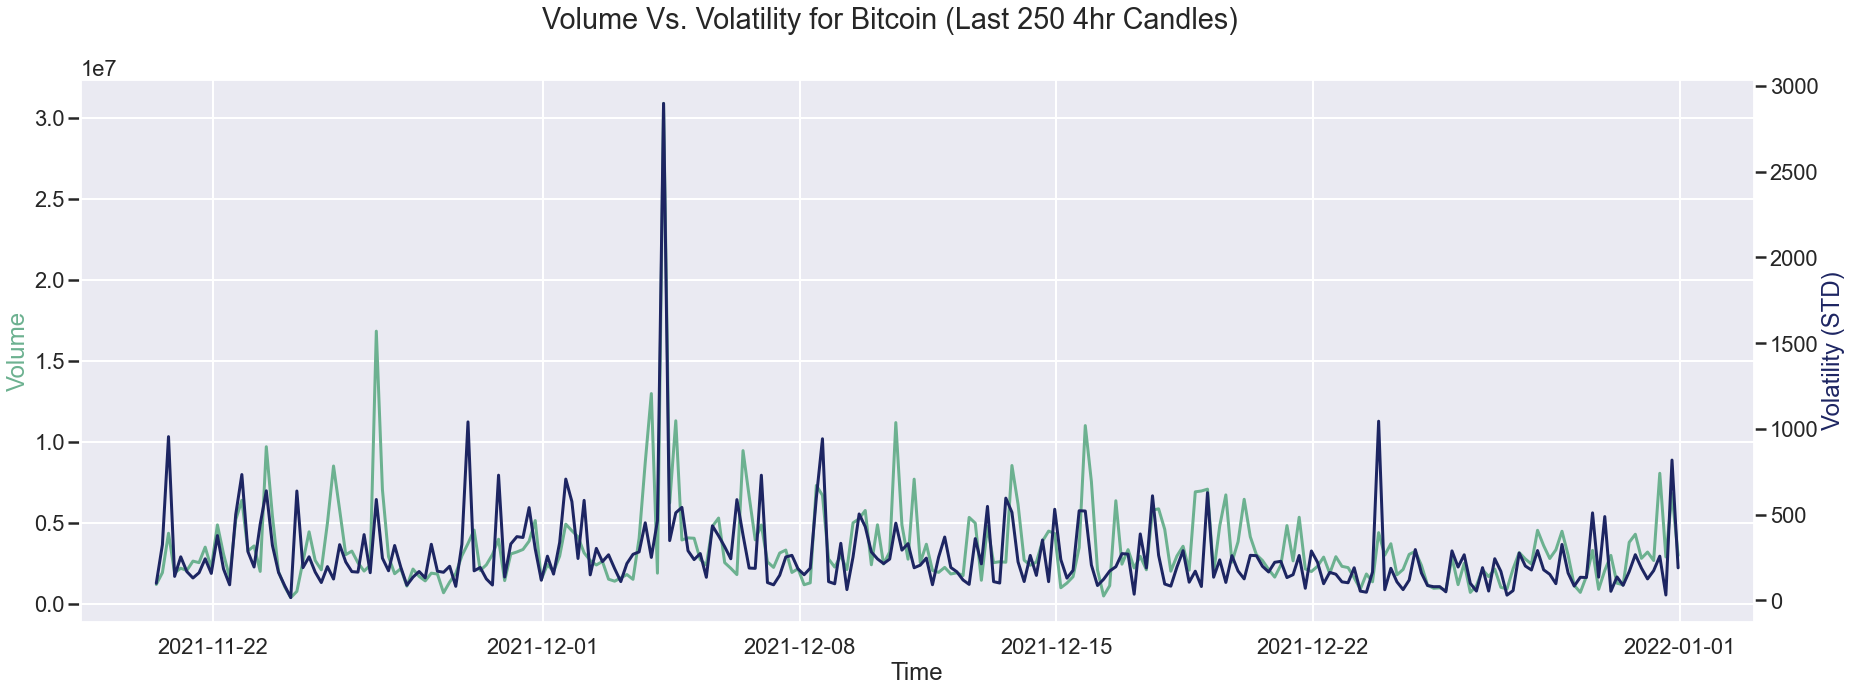

In [131]:
fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.lineplot(data=df, x='dateTime', y='volume', ax=ax1, color=my_colors[0])
sns.lineplot(data=df, x='dateTime', y='volatility', ax=ax2, color=my_colors[1])

ax1.set_xlabel('Time')
ax1.set_ylabel('Volume', color=my_colors[0])
ax2.set_ylabel('Volatility (STD)', color=my_colors[1])
ax2.grid(False)
fig.suptitle(f'Volume Vs. Volatility for Bitcoin (Last {num_candles} 4hr Candles)')

plt.savefig(f'USDT_BTC_volume_vs_volatility_last_{num_candles}_candles.png')
plt.show()